<a href="https://colab.research.google.com/github/rahulyad011/intrusion-detection/blob/main/NIDS1_UNSW_NB15_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model
import pickle # saving and loading trained model
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importing library for support vector machine classifier
from sklearn.svm import SVC

# MLP requirements 
from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model

# LSTM requirements 
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

# evaluation metrices
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import det_curve

# representation of model layers
from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bin_data_total = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/nids_project_data/UNSW_NB15_data/bin_data_processed.csv")
bin_data_total.drop(bin_data_total.columns[0],axis=1,inplace=True)
bin_data_total

,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp-data,service_http,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0,0,0,0,1,0,1,0,0,0,...,1,1,2,0,0,0,1,2,0,0
1,0,0,0,0,1,0,1,0,0,0,...,1,1,2,0,0,0,1,2,0,0
2,0,0,0,0,1,0,1,0,0,0,...,1,1,3,0,0,0,1,3,0,0
3,0,0,0,0,1,0,1,0,0,0,...,2,1,3,0,0,0,2,3,0,0
4,0,0,0,0,1,0,1,0,0,0,...,2,1,3,0,0,0,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0,0,0,0,1,0,0,1,0,0,...,24,13,24,0,0,0,24,24,0,1
257669,0,0,0,1,0,0,1,0,0,0,...,1,1,2,0,0,0,1,1,0,1
257670,0,0,0,0,1,0,0,1,0,0,...,3,3,13,0,0,0,3,12,0,1
257671,0,0,0,0,1,0,0,1,0,0,...,30,14,30,0,0,0,30,30,0,1


In [ ]:
# distribution of label class before sampling
data_size = bin_data_total.shape[0]
# data_size
bin_data_total.label.value_counts()/data_size

1    0.639077
0    0.360923
Name: label, dtype: float64

In [ ]:
# numeric feature normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

numeric_cols = bin_data_total.select_dtypes(['number']).columns
numeric_cols = numeric_cols.drop('label')
flag = 0
scaler = None
if flag:
  # using standard scaler for normalizing
  scaler = StandardScaler()
else:
  # using minmax scaler for normalizing
  # to avoid negative values after scaling
  scaler = MinMaxScaler()

def normalization_train(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = scaler.fit_transform(arr.reshape(len(arr),1))
  return df

def normalization_test(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = scaler.transform(arr.reshape(len(arr),1))
  return df

# numeric_cols

In [ ]:
# sampling data taking only 50% of the data
# bin_data = bin_data_total.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.5))
bin_data = bin_data_total
bin_data

,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp-data,service_http,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0,0,0,0,1,0,1,0,0,0,...,1,1,2,0,0,0,1,2,0,0
1,0,0,0,0,1,0,1,0,0,0,...,1,1,2,0,0,0,1,2,0,0
2,0,0,0,0,1,0,1,0,0,0,...,1,1,3,0,0,0,1,3,0,0
3,0,0,0,0,1,0,1,0,0,0,...,2,1,3,0,0,0,2,3,0,0
4,0,0,0,0,1,0,1,0,0,0,...,2,1,3,0,0,0,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0,0,0,0,1,0,0,1,0,0,...,24,13,24,0,0,0,24,24,0,1
257669,0,0,0,1,0,0,1,0,0,0,...,1,1,2,0,0,0,1,1,0,1
257670,0,0,0,0,1,0,0,1,0,0,...,3,3,13,0,0,0,3,12,0,1
257671,0,0,0,0,1,0,0,1,0,0,...,30,14,30,0,0,0,30,30,0,1


In [ ]:
number_of_cols = bin_data.shape[1]

In [ ]:
# distribution of label class after sampling
data_size = bin_data.shape[0]
bin_data.label.value_counts()/data_size

1    0.639077
0    0.360923
Name: label, dtype: float64

In [ ]:
model_selection = {
    0 : "ALL",
    2 : "MLP",
    3 : "LSTM",
    4 : "AE"
}
model_flag = 0
svm_enable = 1

In [ ]:
X = bin_data.iloc[:,0:number_of_cols] # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = bin_data['label'] # target attribute

In [ ]:
# splitting the dataset 75% for training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42) 

In [ ]:
# calling the normalization() function
X_train = normalization_train(X_train,numeric_cols)
X_train.head()

,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp-data,service_http,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
92000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.032258,0.0,0.0,0.0,0.000000,0.032787,0.0,0
192145,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0.0,1
3245,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.032258,0.0,0.0,0.0,0.016949,0.032787,0.0,1
45792,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1
250330,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0.0,1


In [ ]:
# calling the normalization() function
X_test = normalization_test(X_test,numeric_cols)
X_test.head()

,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp-data,service_http,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
122637,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,3.0,4.0,0.0,0
137118,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,6.0,0.0,0.0,0.0,8.0,6.0,0.0,1
245289,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,17.0,17.0,17.0,0.0,0.0,0.0,18.0,17.0,0.0,1
221262,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,32.0,14.0,36.0,0.0,0.0,0.0,32.0,36.0,0.0,1
31408,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0


## **Linear Support Vector Machine Classifier (Binary Classification) **
to enable make the svm_enable = 1 in the above cell

In [ ]:
if svm_enable:
  # using kernel as linear 
  lsvm = SVC(kernel='linear',gamma='auto') 
  lsvm.fit(X_train,y_train) # training model on training dataset

In [ ]:
if svm_enable:
  pkl_filename = "/content/drive/MyDrive/Colab_Notebooks/Models/lsvm_binary_unsw_nb15.pkl"
  if (not path.isfile(pkl_filename)):
    # saving the trained model to disk
    with open(pkl_filename, 'wb') as file:
      pickle.dump(lsvm, file)
    print("Saved model to disk")
    # loading the trained model from disk
    with open(pkl_filename, 'rb') as file:
      lsvm = pickle.load(file)
    print("Loaded model from disk") 

In [ ]:
if svm_enable:
  y_pred = lsvm.predict(X_test) # predicting target attribute on testing dataset
  ac = accuracy_score(y_test, y_pred)*100 # calculating accuracy of predicted data
  print("LSVM-Classifier Binary Set-Accuracy is ", ac)

LSVM-Classifier Binary Set-Accuracy is  32.56803117092783


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.datasets import make_classification
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# X, y = make_classification(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=0)
# cm = confusion_matrix(y_test, y_pred, labels=lsvm.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=lsvm.classes_)
# disp.plot()

# plt.show()

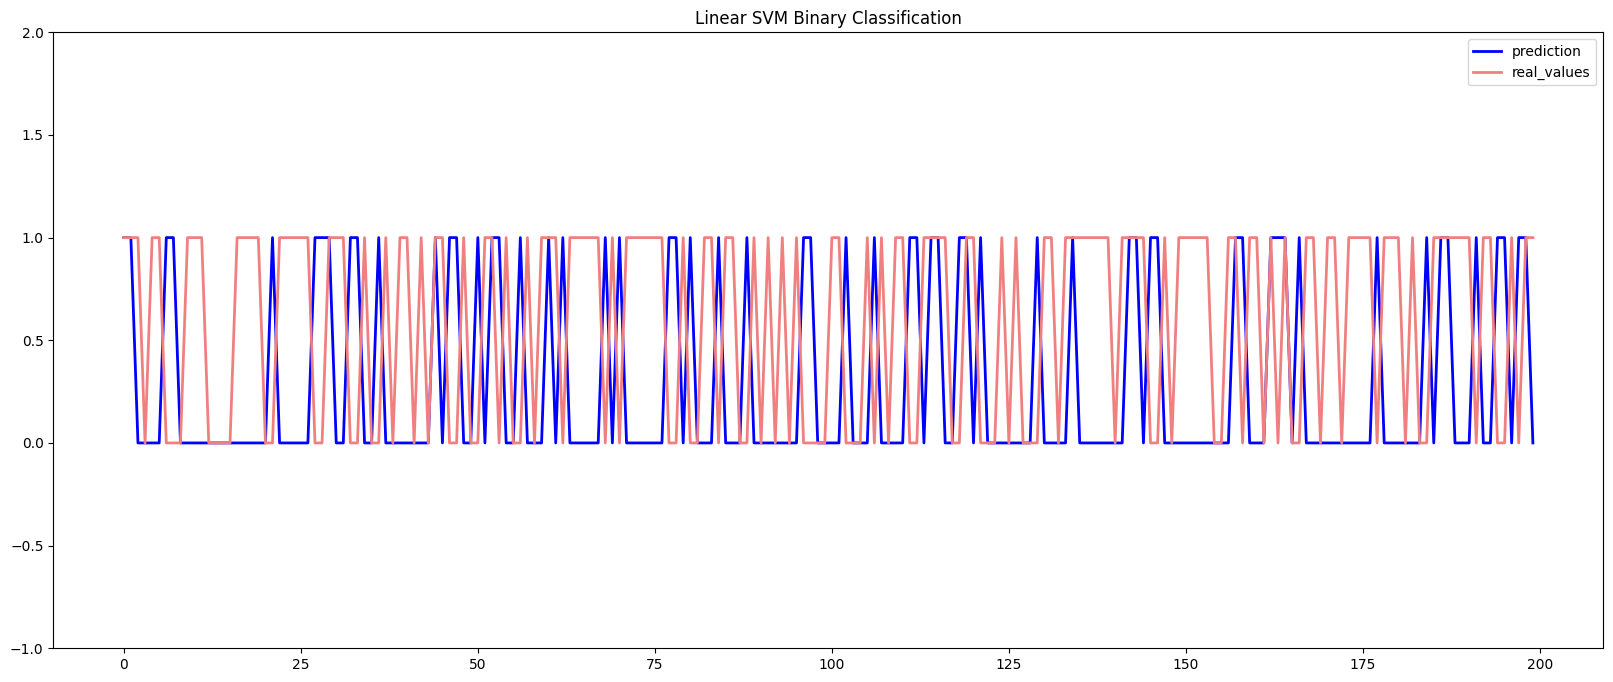

In [ ]:
if svm_enable:
  plt.figure(figsize=(20,8))
  plt.plot(y_pred[300:500], label="prediction", linewidth=2.0,color='blue')
  plt.plot(y_test[300:500].values, label="real_values", linewidth=2.0,color='lightcoral')
  plt.legend(loc="best")
  plt.ylim((-1,2))
  plt.title("Linear SVM Binary Classification")
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/lsvm_real_pred_bin.png')
  plt.show()

In [ ]:
if svm_enable:
  target_names = ['class 0', 'class 1']
  print(classification_report(y_test, y_pred, target_names=target_names))
  fpr, fnr, thresholds = det_curve(y_test, y_pred)
  print("False Positive Rate - ", fpr)
  print("False Negative Rate - ", fnr)
  print("Thresholds - ", thresholds)

              precision    recall  f1-score   support

     class 0       0.27      0.52      0.36     23243
     class 1       0.44      0.22      0.29     41176

    accuracy                           0.33     64419
   macro avg       0.36      0.37      0.32     64419
weighted avg       0.38      0.33      0.31     64419

False Positive Rate -  [1.         0.47859571]
False Negative Rate -  [0.         0.78480183]
Thresholds -  [0 1]


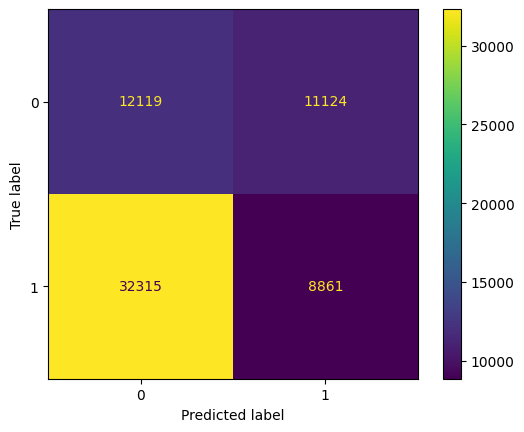

In [ ]:
if svm_enable:
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  clf = lsvm
  cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
  disp.plot()

  plt.show()

## **Multi Layer Perceptron Classifier (Binary Classification)**

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  mlp = Sequential() # creating model

  # adding input layer and first layer with 50 neurons
  mlp.add(Dense(units=50, input_dim=X_train.shape[1], activation='relu'))
  # output layer with sigmoid activation
  mlp.add(Dense(units=1,activation='sigmoid'))

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # defining loss function, optimizer, metrics and then compiling model
  mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # summary of model layers
  mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 50)                2900      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,951
Trainable params: 2,951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # training the model on training dataset
  history = mlp.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
31/31 [==============================] - 1s 11ms/step - loss: 0.5348 - accuracy: 0.8302 - val_loss: 0.4454 - val_accuracy: 0.8953
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.3853 - accuracy: 0.9156 - val_loss: 0.3280 - val_accuracy: 0.9289
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.2855 - accuracy: 0.9403 - val_loss: 0.2441 - val_accuracy: 0.9504
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2131 - accuracy: 0.9575 - val_loss: 0.1817 - val_accuracy: 0.9635
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1592 - accuracy: 0.9712 - val_loss: 0.1366 - val_accuracy: 0.9814
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1205 - accuracy: 0.9878 - val_loss: 0.1041 - val_accuracy: 0.9958
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0924 - accuracy: 0.9960 - val_loss: 0.0804 - val_accuracy: 0.9975
Epoch 8/100


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/mlp_binary.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/mlp_binary.h5'
  if (not path.isfile(filepath)):
    # serialize model to JSON
    mlp_json = mlp.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(mlp_json)

    # serialize weights to HDF5
    mlp.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    mlp = model_from_json(loaded_model_json)

    # load weights into new model
    mlp.load_weights(weightspath)
    print("Loaded model from disk")

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # defining loss function, optimizer, metrics and then compiling model
  mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # predicting target attribute on testing dataset
  test_results = mlp.evaluate(X_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}')

2014/2014 [==============================] - 5s 3ms/step - loss: 97819016.0000 - accuracy: 0.7314
Test results - Loss: 97819016.0 - Accuracy: 73.1430172920227


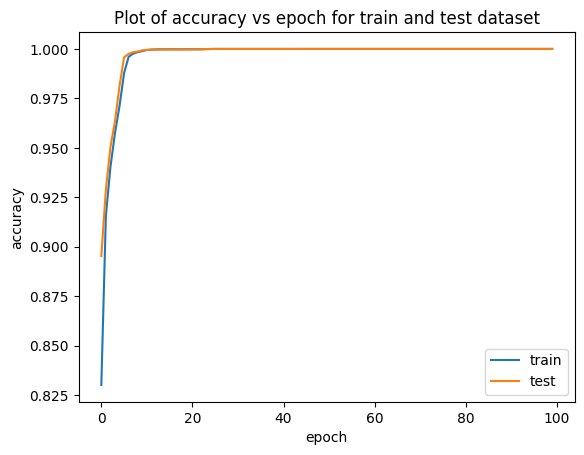

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":  
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary_accuracy.png')
  plt.show()

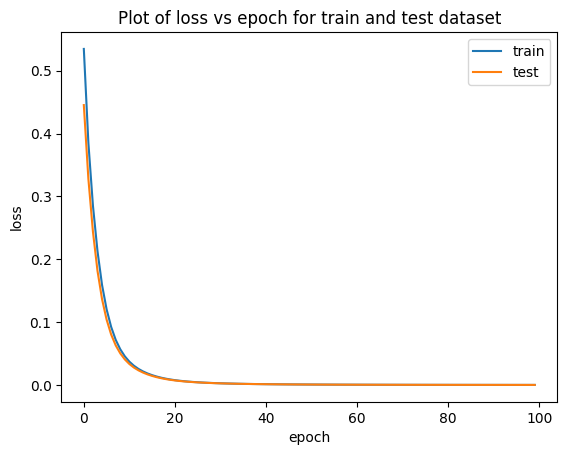

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Plot of loss vs epoch for train and test dataset')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary_loss.png')
  plt.show()

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # representation of model layers
  from keras.utils.vis_utils import plot_model
  plot_model(mlp, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary.png', show_shapes=True,)

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  y_pred = mlp.predict(X_test).ravel()
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  auc = auc(fpr, tpr)

2014/2014 [==============================] - 3s 1ms/step


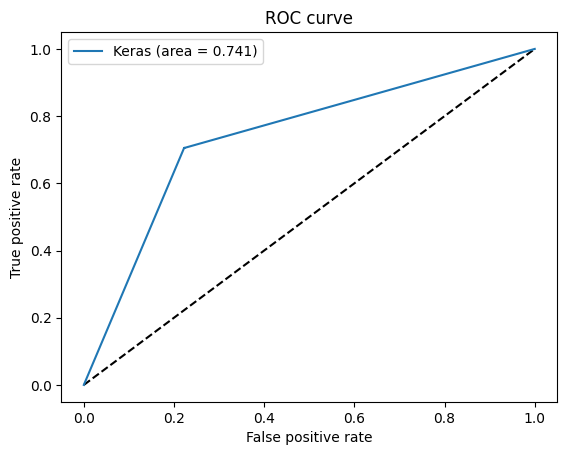

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary_roc.png')
  plt.show()

In [ ]:
# real_data_kdd = bin_data.copy()

# # Names of the columns that are discrete
# cat_cols = real_data_kdd.select_dtypes(['object']).columns
# # cat_cols
# test_data = real_data_kdd.iloc[:999]

# corr= test_data.corr()
# corr_y = abs(corr['label'])
# highest_corr = corr_y
# highest_corr.sort_values(ascending=True)

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  y_classes = (mlp.predict(X_test)>0.5).astype('int32')

2014/2014 [==============================] - 3s 1ms/step


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  print("Recall Score - ",recall_score(y_test,y_classes))
  print("F1 Score - ",f1_score(y_test,y_classes))
  print("Precision Score - ",precision_score(y_test,y_classes))
  fpr, fnr, thresholds = det_curve(y_test, y_classes)
  print("False Positive Rate - ", fpr)
  print("False Negative Rate - ", fnr)
  print("Thresholds - ", thresholds)

Recall Score -  0.7055080629492908
F1 Score -  0.770546809724009
Precision Score -  0.8487947406866326
False Positive Rate -  [1.         0.22264768]
False Negative Rate -  [0.         0.29449194]
Thresholds -  [0 1]


              precision    recall  f1-score   support

           0       0.60      0.78      0.68     23243
           1       0.85      0.71      0.77     41176

    accuracy                           0.73     64419
   macro avg       0.72      0.74      0.72     64419
weighted avg       0.76      0.73      0.74     64419



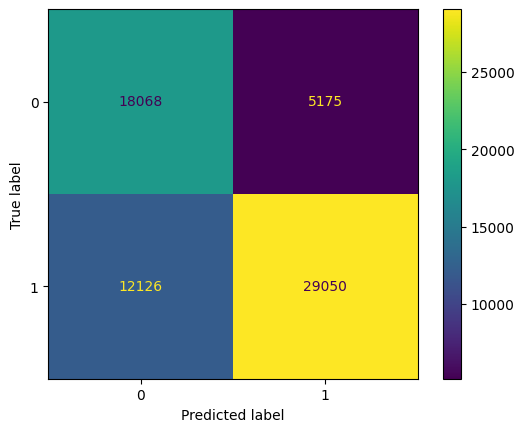

In [ ]:
print(classification_report(y_test, y_classes, target_names=['0', '1']))
cm = confusion_matrix(y_test, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()

plt.show()

# **Correlation** Matrix of Features

In [ ]:
corr= bin_data.corr()
corr_y = abs(corr['label'])
highest_corr = corr_y[corr_y >0.3]
highest_corr.sort_values(ascending=True)

state_FIN           0.309305
ct_src_dport_ltm    0.318518
rate                0.335883
dwin                0.339166
state_CON           0.345195
dload               0.352169
swin                0.364877
proto_tcp           0.364981
ct_dst_sport_ltm    0.371672
ct_state_ttl        0.476559
state_INT           0.516735
sttl                0.624082
label               1.000000
Name: label, dtype: float64

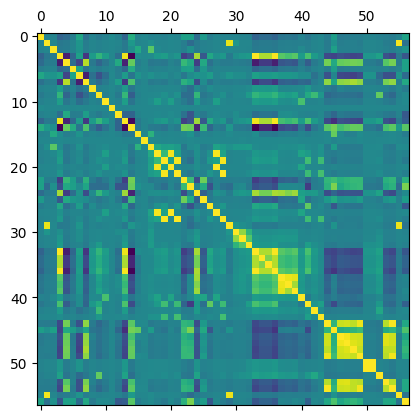

In [ ]:
plt.matshow(corr)
plt.show()

## **LSTM Classifier**

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
# y_train.shape   #(18896,)
X_train.shape

(193254, 57)

In [ ]:
y_train = np.array(y_train)
type(y_train)

numpy.ndarray

In [ ]:
x_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
x_train.shape

(193254, 1, 57)

In [ ]:
x_train.shape[2]

57

In [ ]:
x_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
x_test.shape

(64419, 1, 57)

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  lst = Sequential()
  # input layer and LSTM layer with 50 neurons
  input_features = x_train.shape[2]
  lst.add(LSTM(50,input_dim=input_features))

  # outpute layer with sigmoid activation
  lst.add(Dense(1,activation='sigmoid'))

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # defining loss function, optimizer, metrics and then compiling model
  lst.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # summary of model layers
  lst.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                21600     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 21,651
Trainable params: 21,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # training the model on training dataset
  history = lst.fit(x_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
31/31 [==============================] - 3s 20ms/step - loss: 0.6404 - accuracy: 0.6635 - val_loss: 0.5689 - val_accuracy: 0.7767
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.5099 - accuracy: 0.8069 - val_loss: 0.4511 - val_accuracy: 0.8320
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.4021 - accuracy: 0.8554 - val_loss: 0.3513 - val_accuracy: 0.8895
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.3083 - accuracy: 0.9365 - val_loss: 0.2638 - val_accuracy: 0.9476
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2290 - accuracy: 0.9488 - val_loss: 0.1938 - val_accuracy: 0.9499
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1677 - accuracy: 0.9581 - val_loss: 0.1414 - val_accuracy: 0.9678
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1227 - accuracy: 0.9772 - val_loss: 0.1041 - val_accuracy: 0.9839
Epoch 8/100


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/lst_binary_unsw_nb15.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/lst_binary_unsw_nb15.h5'
  if (not path.isfile(filepath)):
    # serialize model to JSON
    lst_json = lst.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(lst_json)

    # serialize weights to HDF5
    lst.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    lst = model_from_json(loaded_model_json)

    # load weights into new model
    lst.load_weights(weightspath)
    print("Loaded model from disk")

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # load json and create model
  json_file = open(filepath, 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  lst = model_from_json(loaded_model_json)

  # load weights into new model
  lst.load_weights(weightspath)
  print("Loaded model from disk")

Loaded model from disk


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # defining loss function, optimizer, metrics and then compiling model
  lst.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # predicting target attribute on testing dataset
  test_results = lst.evaluate(x_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

2014/2014 [==============================] - 6s 3ms/step - loss: 1.8274 - accuracy: 0.3815
Test results - Loss: 1.8274213075637817 - Accuracy: 38.145577907562256%


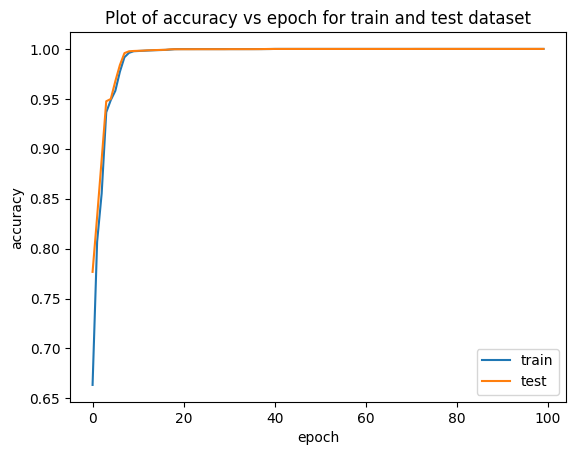

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/lstm_binary_accuracy.png')
  plt.show()

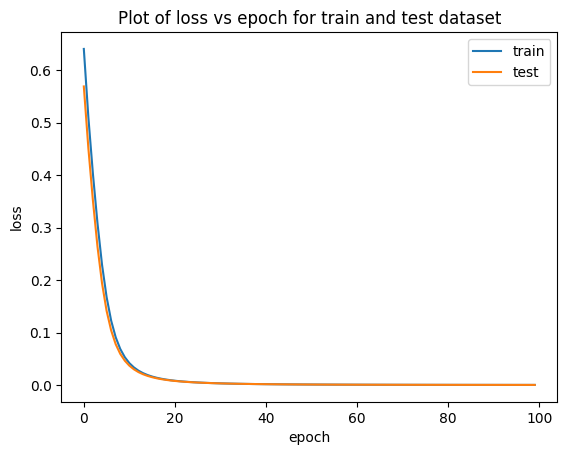

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("Plot of loss vs epoch for train and test dataset")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/lstm_binary_loss.png')
  plt.show()

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # representation of model layers
  plot_model(lst, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/lstm_binary.png', show_shapes=True,)

In [ ]:
y_test = np.array(y_test)
y_test.shape

(64419,)

In [ ]:
type(y_test)

numpy.ndarray

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  y_classes = (lst.predict(x_test)>0.5).astype('int32')

2014/2014 [==============================] - 5s 2ms/step


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  print("Recall Score - ",recall_score(y_test,y_classes))
  print("F1 Score - ",f1_score(y_test,y_classes))
  print("Precision Score - ",precision_score(y_test,y_classes))
  fpr, fnr, thresholds = det_curve(y_test, y_classes)
  print("False Positive Rate - ", fpr)
  print("False Negative Rate - ", fnr)
  print("Thresholds - ", thresholds)

Recall Score -  0.14960170973382553
F1 Score -  0.23616915232143543
Precision Score -  0.5605095541401274
False Positive Rate -  [1.        0.2078045]
False Negative Rate -  [0.         0.85039829]
Thresholds -  [0 1]


              precision    recall  f1-score   support

           0       0.34      0.79      0.48     23243
           1       0.56      0.15      0.24     41176

    accuracy                           0.38     64419
   macro avg       0.45      0.47      0.36     64419
weighted avg       0.48      0.38      0.32     64419



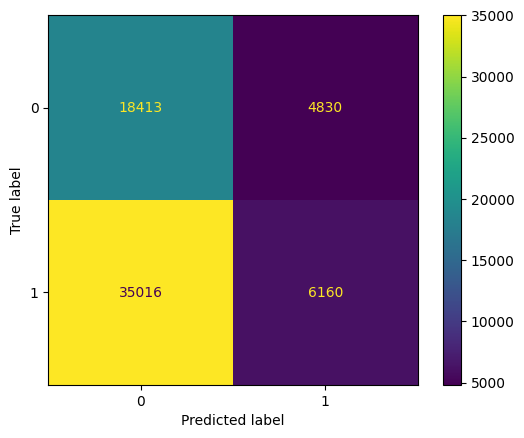

In [ ]:
print(classification_report(y_test, y_classes, target_names=['0', '1']))
cm = confusion_matrix(y_test, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()

plt.show()

## **Auto Encoder**

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # splitting the dataset 75% for training and 25% testing
  X_train, X_test = train_test_split(bin_data, test_size=0.25, random_state=42)

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # dataset excluding target attribute (encoded, one-hot-encoded,original)
  X_train = X_train.drop(['label'],axis=1) 

  y_test = X_test['label'] # target attribute

  # dataset excluding target attribute (encoded, one-hot-encoded,original)
  X_test = X_test.drop(['label'],axis=1)
  # calling the normalization() function
  X_train = normalization_train(X_train,numeric_cols)
  X_test = normalization_test(X_test,numeric_cols)
  X_train = X_train.values
  X_test = X_test.values
  y_test = y_test.values

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  input_dim = X_train.shape[1]
  encoding_dim = 50

  #input layer
  input_layer = Input(shape=(input_dim, ))
  #encoding layer with 50 neurons
  encoder = Dense(encoding_dim, activation="relu")(input_layer)           
  #decoding and output layer
  output_layer = Dense(input_dim, activation='softmax')(encoder)

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # creating model with input, encoding, decoding, output layers
  autoencoder = Model(inputs=input_layer, outputs=output_layer)

  # defining loss function, optimizer, metrics and then compiling model
  autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # summary of model layers
  autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 56)]              0         
                                                                 
 dense_10 (Dense)            (None, 50)                2850      
                                                                 
 dense_11 (Dense)            (None, 56)                2856      
                                                                 
Total params: 5,706
Trainable params: 5,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # training the model on training dataset
  history = autoencoder.fit(X_train, X_train, epochs=100,batch_size=500,validation_data=(X_test, X_test)).history

Epoch 1/100
387/387 [==============================] - 2s 4ms/step - loss: 0.0759 - accuracy: 0.2478 - val_loss: 103740657247453184.0000 - val_accuracy: 2.4837e-04
Epoch 2/100
387/387 [==============================] - 1s 3ms/step - loss: 0.0708 - accuracy: 0.2289 - val_loss: 103740657247453184.0000 - val_accuracy: 2.6390e-04
Epoch 3/100
387/387 [==============================] - 1s 4ms/step - loss: 0.0706 - accuracy: 0.1858 - val_loss: 103740657247453184.0000 - val_accuracy: 2.6390e-04
Epoch 4/100
387/387 [==============================] - 1s 4ms/step - loss: 0.0704 - accuracy: 0.2113 - val_loss: 103740657247453184.0000 - val_accuracy: 2.6390e-04
Epoch 5/100
387/387 [==============================] - 1s 4ms/step - loss: 0.0704 - accuracy: 0.2128 - val_loss: 103740657247453184.0000 - val_accuracy: 2.6390e-04
Epoch 6/100
387/387 [==============================] - 2s 5ms/step - loss: 0.0704 - accuracy: 0.1815 - val_loss: 103740657247453184.0000 - val_accuracy: 2.6390e-04
Epoch 7/100
387/

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/ae_binary_unsw_nb15.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/ae_binary_unsw_nb15.h5'
  if (not path.isfile(filepath)): 
    # serialize model to JSON
    autoencoder_json = autoencoder.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(autoencoder_json)

    # serialize weights to HDF5
    autoencoder.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    autoencoder = model_from_json(loaded_model_json)

    # load weights into new model
    autoencoder.load_weights(weightspath)
    print("Loaded model from disk")

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # defining loss function, optimizer, metrics and then compiling model
  autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # predicting target attribute on testing dataset
  test_results = autoencoder.evaluate(X_test, X_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

2014/2014 [==============================] - 5s 2ms/step - loss: 103740528398434304.0000 - accuracy: 2.6390e-04
Test results - Loss: 1.037405283984343e+17 - Accuracy: 0.00026389729464426637%


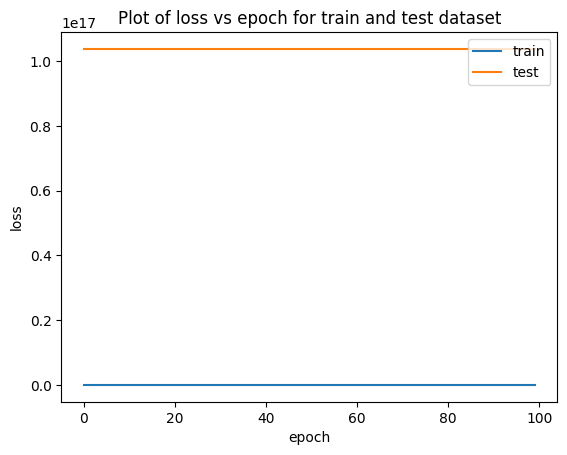

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title("Plot of loss vs epoch for train and test dataset")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary_loss.png')
  plt.show()

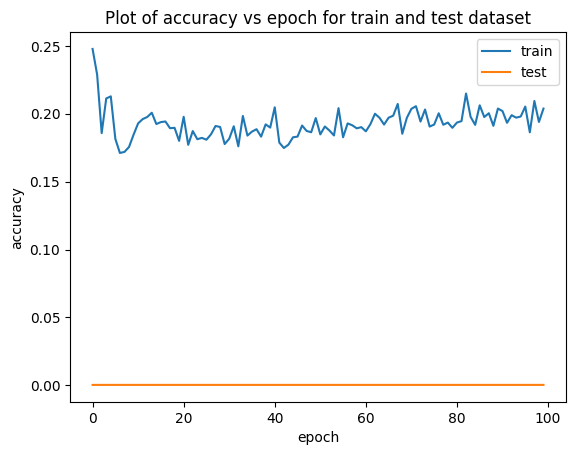

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary_accuracy.png')
  plt.show()

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # representation of model layers
  plot_model(autoencoder, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary.png', show_shapes=True,)

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # calculating reconstruction error 
  predictions = autoencoder.predict(X_test)

2014/2014 [==============================] - 3s 1ms/step


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  mse = np.mean(np.power(X_test - predictions, 2), axis=1)
  error_df = pd.DataFrame({'reconstruction_error': mse,
                           'true_class': y_test})

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  error_df.describe()
  print(predictions.shape)

(64419, 56)


## **AE Classifier**

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  i_dim = predictions.shape[1]

  #input layer
  i_layer = Input(shape=(i_dim, ))
  #hidden layer with 50 neurons
  fvector = Dense(50, activation="sigmoid")(i_layer)                    
  #doutput layer
  o_layer = Dense(1, activation='sigmoid')(fvector)

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # creating model with input, encoding, decoding, output layers
  ae_classifier = Model(inputs=i_layer, outputs=o_layer)

  # defining loss function, optimizer, metrics and then compiling model
  ae_classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # summary of model layers
  ae_classifier.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 56)]              0         
                                                                 
 dense_12 (Dense)            (None, 50)                2850      
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2,901
Trainable params: 2,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # training the model on training dataset
  his = ae_classifier.fit(predictions, y_test, epochs=300,batch_size=500, validation_split=0.2).history

Epoch 1/300
104/104 [==============================] - 1s 5ms/step - loss: 0.6827 - accuracy: 0.5609 - val_loss: 0.6209 - val_accuracy: 0.6455
Epoch 2/300
104/104 [==============================] - 0s 4ms/step - loss: 0.6128 - accuracy: 0.6649 - val_loss: 0.5994 - val_accuracy: 0.7481
Epoch 3/300
104/104 [==============================] - 0s 4ms/step - loss: 0.5927 - accuracy: 0.7454 - val_loss: 0.5819 - val_accuracy: 0.7479
Epoch 4/300
104/104 [==============================] - 0s 4ms/step - loss: 0.5771 - accuracy: 0.7456 - val_loss: 0.5698 - val_accuracy: 0.7483
Epoch 5/300
104/104 [==============================] - 0s 4ms/step - loss: 0.5664 - accuracy: 0.7458 - val_loss: 0.5616 - val_accuracy: 0.7483
Epoch 6/300
104/104 [==============================] - 0s 4ms/step - loss: 0.5598 - accuracy: 0.7458 - val_loss: 0.5573 - val_accuracy: 0.7483
Epoch 7/300
104/104 [==============================] - 0s 4ms/step - loss: 0.5561 - accuracy: 0.7458 - val_loss: 0.5548 - val_accuracy: 0.7483

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/ae_classifier_binary_unsw_nb15.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/ae_classifier_binary_unsw_nb15.h5'
  if (not path.isfile(filepath)): 
    # serialize model to JSON
    ae_classifier_json = ae_classifier.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(ae_classifier_json)

    # serialize weights to HDF5
    ae_classifier.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    ae_classifier = model_from_json(loaded_model_json)

    # load weights into new model
    ae_classifier.load_weights(weightspath)
    print("Loaded model from disk")

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  ae_classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # predicting target attribute on testing dataset
  test_results = ae_classifier.evaluate(X_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

2014/2014 [==============================] - 6s 3ms/step - loss: 0.6349 - accuracy: 0.6334
Test results - Loss: 0.6348815560340881 - Accuracy: 63.34311366081238%


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # representation of model layers
  plot_model(ae_classifier, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/ae_classifier_binary.png', show_shapes=True)

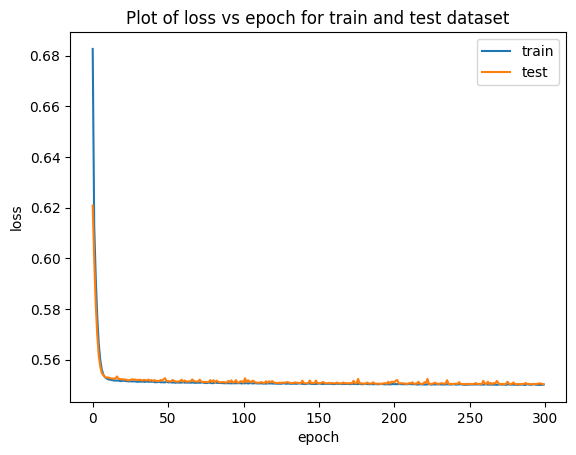

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(his['loss'])
  plt.plot(his['val_loss'])
  plt.title("Plot of loss vs epoch for train and test dataset")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_classifier_binary_loss.png')
  plt.show()

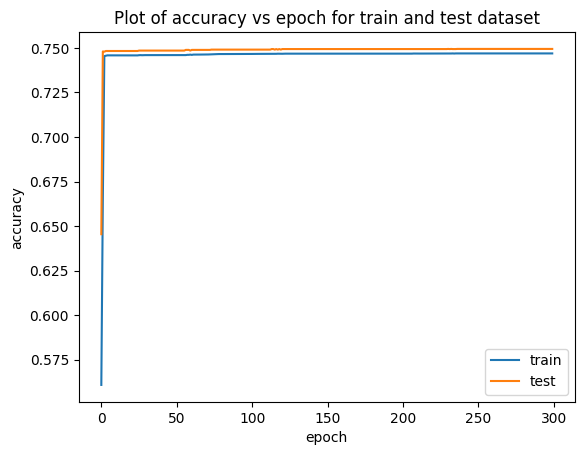

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(his['accuracy'])
  plt.plot(his['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_classifier_binary_accuracy.png')
  plt.show()

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  y_pred = ae_classifier.predict(X_test).ravel()
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  #auc = auc(fpr, tpr)

2014/2014 [==============================] - 3s 1ms/step


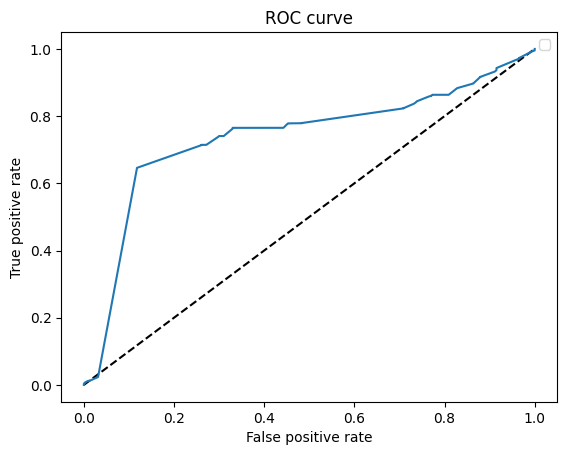

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  plt.plot([0, 1], [0, 1], 'k--')
  #plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
  plt.plot(fpr, tpr)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary_roc.png')
  plt.show()

In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  pred = ae_classifier.predict(X_test)
  y_classes = (ae_classifier.predict(X_test)>0.5).astype('int32')

2014/2014 [==============================] - 3s 1ms/step


In [ ]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  print("Recall Score - ",recall_score(y_test,y_classes))
  print("F1 Score - ",f1_score(y_test,y_classes))
  print("Precision Score - ",precision_score(y_test,y_classes))
  fpr, fnr, thresholds = det_curve(y_test, y_classes)
  print("False Positive Rate - ", fpr)
  print("False Negative Rate - ", fnr)
  print("Thresholds - ", thresholds)

Recall Score -  0.8585098115407033
F1 Score -  0.7496235977691541
Precision Score -  0.6652489743686251
False Positive Rate -  [1.         0.76530568]
False Negative Rate -  [0.         0.14149019]
Thresholds -  [0 1]


              precision    recall  f1-score   support

           0       0.48      0.23      0.32     23243
           1       0.67      0.86      0.75     41176

    accuracy                           0.63     64419
   macro avg       0.57      0.55      0.53     64419
weighted avg       0.60      0.63      0.59     64419



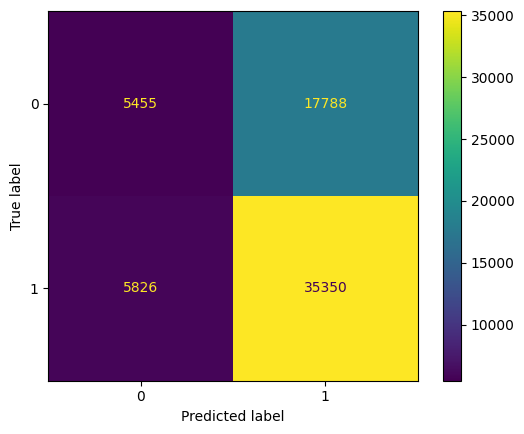

In [ ]:
print(classification_report(y_test, y_classes, target_names=['0', '1']))
cm = confusion_matrix(y_test, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()

plt.show()